%%time
<h1>Introduction</h1>
Rusty Bargain is building an application that customers will be able to use to find the market value of their car. They want to use data that they already have from users who have posted their cars to sell, which includes technical and trim data about their car as well as price data. To that end, they are looking for a machine learning model that will be able to predict the market value of cars in an accurate and timely manner.

This project takes a look at five different machine learning models, two of which use gradient boosting methods, to evaluate which will be the fastest and most accurate for Rusty Bargain to implement, and then makes a recommendation based on the findings.

Import statements necessary for this project

In [1]:
%%time
import pandas as pd
import numpy as np
from IPython.display import display
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression	
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
plt.style.use('ggplot')

CPU times: user 2.39 s, sys: 416 ms, total: 2.81 s
Wall time: 3.18 s


Importing the data

In [2]:
%%time
car_data = pd.read_csv("/Users/admin/Library/Mobile Documents/com~apple~CloudDocs/GitHub/rusty-bargain/car_data.csv", encoding = "utf-8")


CPU times: user 572 ms, sys: 108 ms, total: 680 ms
Wall time: 703 ms


Looking at a sample of the data and information about the dataframe

In [3]:
%%time
display(car_data.sample(10))
car_data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
176495,07/04/2016 12:25,15300,small,2015,manual,90,polo,20000,5,petrol,volkswagen,no,07/04/2016 00:00,0,65185,07/04/2016 12:25
140463,16/03/2016 00:36,0,NaN,2017,manual,75,fabia,150000,9,petrol,skoda,no,16/03/2016 00:00,0,28790,16/03/2016 08:47
87828,09/03/2016 19:40,5400,coupe,1992,manual,169,other,150000,1,petrol,nissan,no,09/03/2016 00:00,0,71067,17/03/2016 23:45
136779,09/03/2016 16:56,11800,sedan,2010,auto,122,golf,50000,5,petrol,volkswagen,no,09/03/2016 00:00,0,16540,05/04/2016 05:46
26756,27/03/2016 22:48,4900,NaN,2016,manual,105,NaN,150000,6,gasoline,volkswagen,NaN,27/03/2016 00:00,0,31785,02/04/2016 00:45
48391,23/03/2016 17:39,1165,wagon,2003,manual,180,omega,150000,3,petrol,opel,no,23/03/2016 00:00,0,99880,31/03/2016 04:45
242965,09/03/2016 11:54,2999,sedan,1984,auto,75,golf,80000,7,petrol,volkswagen,NaN,09/03/2016 00:00,0,66265,24/03/2016 22:46
222929,03/04/2016 14:49,6500,small,2008,manual,80,polo,70000,10,petrol,volkswagen,no,03/04/2016 00:00,0,56170,06/04/2016 21:45
52198,08/03/2016 16:55,8989,small,2013,manual,60,fiesta,50000,7,lpg,ford,no,08/03/2016 00:00,0,40885,07/04/2016 03:16
233325,05/04/2016 12:36,899,sedan,1999,manual,113,laguna,150000,3,gasoline,renault,no,05/04/2016 00:00,0,34212,05/04/2016 12:36


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

<h2>Data Preprocessing</h2>

Updating the column names to meet standard naming conventions

In [4]:
%%time
car_data = car_data.rename(columns={'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear': 'registration_year', 'Gearbox': 'gear_box', 'Power': 'power', 'Model': 'model', 'Mileage': 'mileage', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type', 'Brand': 'brand', 'NotRepaired': 'not_repaired', 'DateCreated': 'date_created', 'NumberOfPictures': 'number_of_pictures', 'PostalCode': 'postal_code', 'LastSeen': 'last_seen'})


CPU times: user 30.7 ms, sys: 19.5 ms, total: 50.2 ms
Wall time: 48.5 ms


In [5]:
%%time
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gear_box            334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   mileage             354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  not_repaired        283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

This code checks for rows that are entirely duplicated. Several were found, so I removed the duplicate rows.

In [6]:
%%time
print(car_data.duplicated().sum())
car_data.drop_duplicates(inplace=True)
print(car_data.duplicated().sum())


262
0
CPU times: user 888 ms, sys: 117 ms, total: 1 s
Wall time: 1.03 s


This code checks for duplicates in different column pairings that I thought might be relevant. However, after getting to a certain point, there were still many duplicates. Since I removed all the duplicate rows, I decided that this endeavor might be fruitless since there are so many variables that might be in common between cars.

In [7]:
%%time
print(car_data.duplicated(subset=['model', 'mileage']).sum())
print(car_data.duplicated(subset=['model', 'mileage', 'postal_code']).sum())
print(car_data.duplicated(subset=['model', 'mileage', 'postal_code', 'date_created']).sum())
print(car_data.duplicated(subset=['model', 'mileage', 'postal_code', 'date_created', 'last_seen']).sum())
print(car_data.duplicated(subset=['model', 'mileage', 'postal_code', 'date_created', 'last_seen', 'number_of_pictures']).sum())
print(car_data.duplicated(subset=['model', 'mileage', 'postal_code', 'date_created', 'last_seen', 'number_of_pictures', 'registration_year']).sum())

351403
141525
27739
1749
1749
1529
CPU times: user 394 ms, sys: 18.6 ms, total: 413 ms
Wall time: 412 ms


The following code blocks check for null values in various columns, then searches for those columns to see what a good filler value might be. The code then adds a value to the missing data. It's worth noting that the columns with missing values are all categorical.

In [8]:
%%time
print(car_data['vehicle_type'].isna().sum())
print(car_data.query('vehicle_type.isna()'))
car_data['vehicle_type'] = car_data['vehicle_type'].fillna('Unknown Type')
print(car_data['vehicle_type'].isna().sum())


37484
            date_crawled  price vehicle_type  registration_year gear_box  \
0       24/03/2016 11:52    480          NaN               1993   manual   
16      01/04/2016 12:46    300          NaN               2016      NaN   
22      23/03/2016 14:52   2900          NaN               2018   manual   
26      10/03/2016 19:38   5555          NaN               2017   manual   
31      29/03/2016 16:57    899          NaN               2016   manual   
...                  ...    ...          ...                ...      ...   
354346  07/03/2016 17:06   2600          NaN               2005     auto   
354351  11/03/2016 23:40   1900          NaN               2000   manual   
354361  09/03/2016 13:37   5250          NaN               2016     auto   
354364  21/03/2016 09:50      0          NaN               2005   manual   
354365  14/03/2016 17:48   2200          NaN               2005      NaN   

        power     model  mileage  registration_month fuel_type  \
0           0  

In [9]:
%%time
print(car_data['model'].isna().sum())
print(car_data.query('model.isna()'))
car_data['model'] = car_data['model'].fillna('Unknown Model')
print(car_data['model'].isna().sum())

19701
            date_crawled  price  vehicle_type  registration_year gear_box  \
1       24/03/2016 10:58  18300         coupe               2011   manual   
59      29/03/2016 15:48      1           suv               1994   manual   
81      03/04/2016 12:56    350         small               1997   manual   
115     20/03/2016 18:53      0         small               1999      NaN   
135     27/03/2016 20:51   1450         sedan               1992   manual   
...                  ...    ...           ...                ...      ...   
354245  07/03/2016 16:37    560         small               2001     auto   
354321  15/03/2016 13:52   9400         wagon               2007   manual   
354338  31/03/2016 19:52    180  Unknown Type               1995      NaN   
354351  11/03/2016 23:40   1900  Unknown Type               2000   manual   
354365  14/03/2016 17:48   2200  Unknown Type               2005      NaN   

        power model  mileage  registration_month fuel_type           

In [10]:
%%time
print(car_data['fuel_type'].isna().sum())
print(car_data.query('fuel_type.isna()'))
car_data['fuel_type'] = car_data['fuel_type'].fillna('Unknown Fuel')
print(car_data['fuel_type'].isna().sum())

32889
            date_crawled  price  vehicle_type  registration_year gear_box  \
9       17/03/2016 10:53    999         small               1998   manual   
13      21/03/2016 21:37   2500         wagon               2004   manual   
26      10/03/2016 19:38   5555  Unknown Type               2017   manual   
36      11/03/2016 11:50   1600         other               1991   manual   
41      30/03/2016 20:38   7500         sedan               2002     auto   
...                  ...    ...           ...                ...      ...   
354339  20/03/2016 12:46   3850   convertible               2006   manual   
354346  07/03/2016 17:06   2600  Unknown Type               2005     auto   
354351  11/03/2016 23:40   1900  Unknown Type               2000   manual   
354361  09/03/2016 13:37   5250  Unknown Type               2016     auto   
354365  14/03/2016 17:48   2200  Unknown Type               2005      NaN   

        power          model  mileage  registration_month fuel_type  

In [11]:
%%time
print(car_data['not_repaired'].isna().sum())
print(car_data.query('not_repaired.isna()'))
car_data['not_repaired'] = car_data['not_repaired'].fillna('Unknown Repair Status')
print(car_data['not_repaired'].isna().sum())

71145
            date_crawled  price  vehicle_type  registration_year gear_box  \
0       24/03/2016 11:52    480  Unknown Type               1993   manual   
2       14/03/2016 12:52   9800           suv               2004     auto   
8       04/04/2016 23:42  14500           bus               2014   manual   
9       17/03/2016 10:53    999         small               1998   manual   
12      15/03/2016 22:49    999         wagon               1995   manual   
...                  ...    ...           ...                ...      ...   
354349  16/03/2016 17:06   5999         wagon               2005   manual   
354356  04/04/2016 11:45    999   convertible               2000   manual   
354357  09/03/2016 11:36   1690         wagon               2004   manual   
354365  14/03/2016 17:48   2200  Unknown Type               2005      NaN   
354368  20/03/2016 19:41   3400         wagon               2002   manual   

        power          model  mileage  registration_month     fuel_ty

In [12]:
%%time
print(car_data['gear_box'].isna().sum())
print(car_data.query('gear_box.isna()'))
car_data['gear_box'] = car_data['gear_box'].fillna('Unknown Gear Box')
print(car_data['gear_box'].isna().sum())

19830
            date_crawled  price  vehicle_type  registration_year gear_box  \
15      11/03/2016 21:39    450         small               1910      NaN   
16      01/04/2016 12:46    300  Unknown Type               2016      NaN   
32      15/03/2016 20:59    245         sedan               1994      NaN   
37      28/03/2016 17:50   1500  Unknown Type               2016      NaN   
40      26/03/2016 22:06      0  Unknown Type               1990      NaN   
...                  ...    ...           ...                ...      ...   
354288  16/03/2016 13:36   3300         wagon               2006      NaN   
354305  03/04/2016 13:46   3500  Unknown Type               1995      NaN   
354329  30/03/2016 20:55    350         small               1996      NaN   
354338  31/03/2016 19:52    180  Unknown Type               1995      NaN   
354365  14/03/2016 17:48   2200  Unknown Type               2005      NaN   

        power          model  mileage  registration_month     fuel_ty

In [13]:
%%time
car_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354107 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354107 non-null  object
 1   price               354107 non-null  int64 
 2   vehicle_type        354107 non-null  object
 3   registration_year   354107 non-null  int64 
 4   gear_box            354107 non-null  object
 5   power               354107 non-null  int64 
 6   model               354107 non-null  object
 7   mileage             354107 non-null  int64 
 8   registration_month  354107 non-null  int64 
 9   fuel_type           354107 non-null  object
 10  brand               354107 non-null  object
 11  not_repaired        354107 non-null  object
 12  date_created        354107 non-null  object
 13  number_of_pictures  354107 non-null  int64 
 14  postal_code         354107 non-null  int64 
 15  last_seen           354107 non-null  object
dtypes: int6

<h2>EDA</h2>

This code conducts brief EDA with pairplots of potentially related columns. I limited these columns in order to make the plots readable. However, as seen in the graphs, there seem to be no related values. Machine Learning is going to be a better way to evaluate this.

/Users/admin/miniconda3/envs/rusty-bargain/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


CPU times: user 38 s, sys: 1.91 s, total: 39.9 s
Wall time: 42.3 s


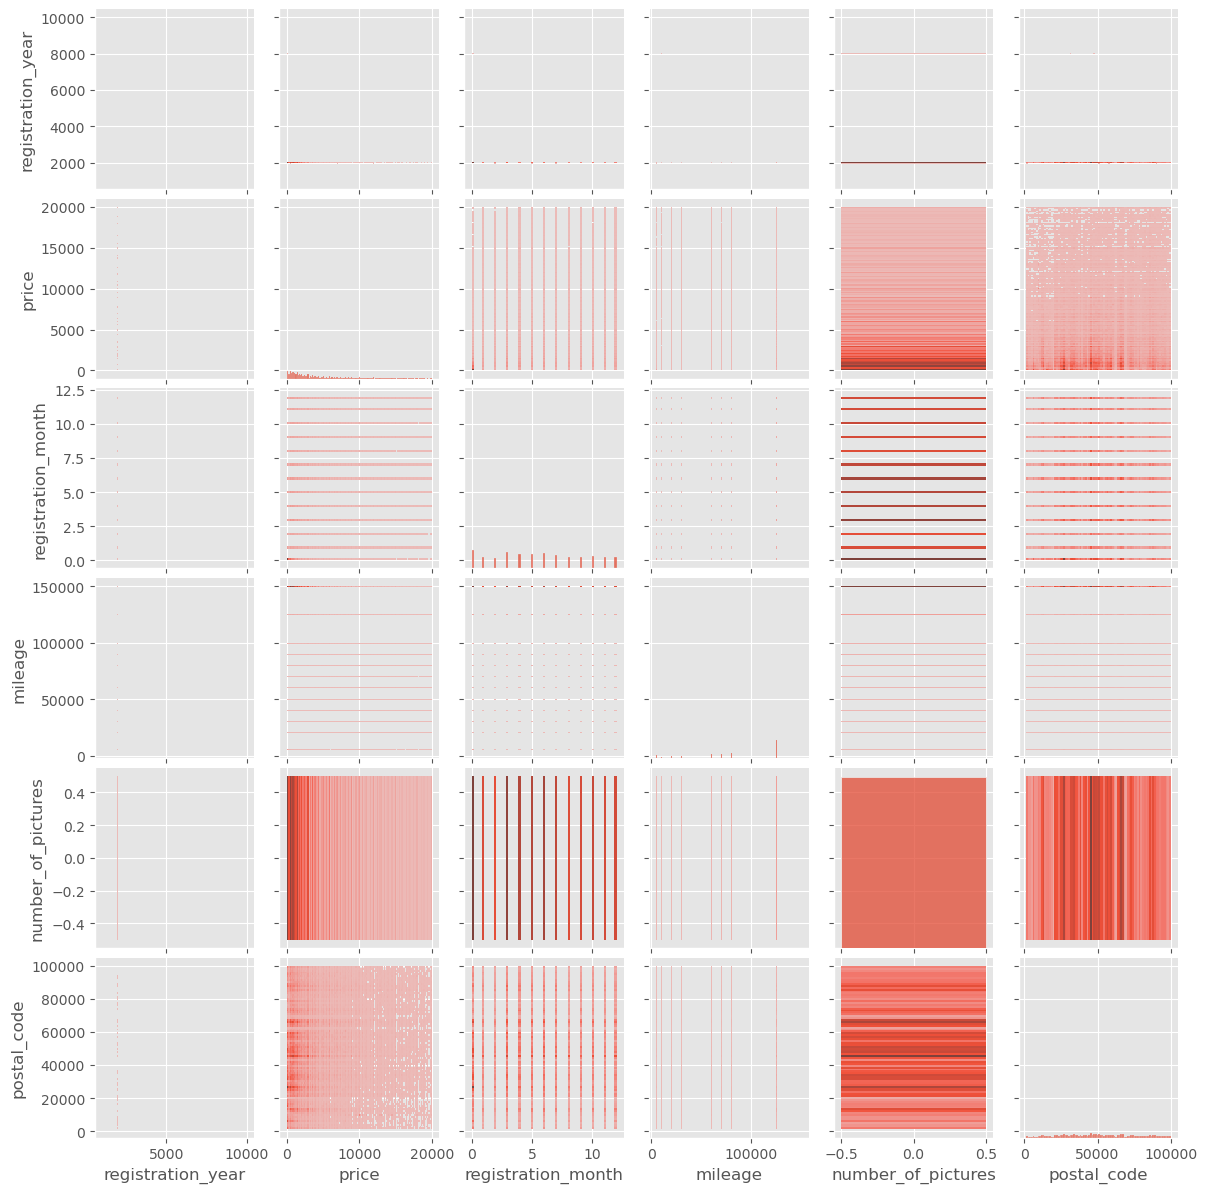

In [14]:
%%time
car_groups = sns.pairplot(car_data, vars= ['registration_year', 'price', 'registration_month', 'mileage', 'number_of_pictures', 'postal_code'], kind='hist')
car_groups.fig.set_size_inches(12, 12)

<h2>Training Machine Learning Models</h2>

This commented code provides the option to delete different columns if runtimes are too long or the kernel dies. I was able to optimize the code in other ways, except for XGBoost which I was not able to get to run no matter what I deleted. If you are having issues, feel free to comment any of these in that you feel are necessary.

In [15]:
'''%%time
del(car_data['number_of_pictures'])
del(car_data['last_seen'])
del(car_data['gear_box'])
del(car_data['registration_year'])
del(car_data['registration_month'])
del(car_data['not_repaired'])
del(car_data['date_created'])
del(car_data['model'])
del(car_data['fuel_type'])
del(car_data['power'])'''




"%%time\ndel(car_data['number_of_pictures'])\ndel(car_data['last_seen'])\ndel(car_data['gear_box'])\ndel(car_data['registration_year'])\ndel(car_data['registration_month'])\ndel(car_data['not_repaired'])\ndel(car_data['date_created'])\ndel(car_data['model'])\ndel(car_data['fuel_type'])\ndel(car_data['power'])"

This code creates a list of categorical features to use in future code

In [16]:
%%time
categorical_features = ['date_crawled', 'last_seen', 'gear_box', 'not_repaired', 'date_created', 'model', 'fuel_type', 'vehicle_type', 'brand']

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


This commented code uses OHE to create encoded categorical features. This is for XGBoost.

In [17]:
'''%%time
car_data_encoded = pd.get_dummies(car_data, columns=categorical_features)'''

'%%time\ncar_data_encoded = pd.get_dummies(car_data, columns=categorical_features)'

This code creates label-encoded categorical values for all models except XGBoost

In [18]:
%%time
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    car_data[col] = le.fit_transform(car_data[col])
    label_encoders[col] = le



CPU times: user 600 ms, sys: 23.6 ms, total: 624 ms
Wall time: 633 ms


This code splits the data into train and test sets, then calls info() to ensure it was done correctly. The commented code does the same for the OHE-encoded dataset.

In [19]:
%%time
X = car_data.drop('price', axis=1)
y = car_data.price

X_train1, X_test, y_train1, y_test = train_test_split (X, y, test_size=0.20, random_state=54321)
X_train, X_valid, y_train, y_valid = train_test_split(X_train1, y_train1, test_size=0.25, random_state=54321)




CPU times: user 148 ms, sys: 32.4 ms, total: 180 ms
Wall time: 179 ms


In [20]:
%%time
X_train.info()
X_test.info()
X_valid.info()

y_train.describe()
y_test.describe()
y_valid.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 212463 entries, 161250 to 344330
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype
---  ------              --------------   -----
 0   date_crawled        212463 non-null  int64
 1   vehicle_type        212463 non-null  int64
 2   registration_year   212463 non-null  int64
 3   gear_box            212463 non-null  int64
 4   power               212463 non-null  int64
 5   model               212463 non-null  int64
 6   mileage             212463 non-null  int64
 7   registration_month  212463 non-null  int64
 8   fuel_type           212463 non-null  int64
 9   brand               212463 non-null  int64
 10  not_repaired        212463 non-null  int64
 11  date_created        212463 non-null  int64
 12  number_of_pictures  212463 non-null  int64
 13  postal_code         212463 non-null  int64
 14  last_seen           212463 non-null  int64
dtypes: int64(15)
memory usage: 25.9 MB
<class 'pandas.core.frame.DataFra

count    70822.000000
mean      4437.110149
std       4530.822350
min          0.000000
25%       1050.000000
50%       2750.000000
75%       6450.000000
max      20000.000000
Name: price, dtype: float64

In [21]:
'''%%time
X_encoded = car_data_encoded.drop('price', axis=1)
y_encoded = car_data_encoded.price
X_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test = train_test_split(X_encoded, y_encoded, test_size=0.25, random_state=54321)'''

"%%time\nX_encoded = car_data_encoded.drop('price', axis=1)\ny_encoded = car_data_encoded.price\nX_encoded_train, X_encoded_test, y_encoded_train, y_encoded_test = train_test_split(X_encoded, y_encoded, test_size=0.25, random_state=54321)"

This code scales the numeric values for all models

In [22]:
%%time
numeric = ['mileage', 'postal_code', 'registration_year', 'registration_month', 'number_of_pictures', 'power']


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


In [23]:
%%time
def scaling(features_train, features_test, features_valid):
    scaler = StandardScaler()
    scaler.fit(features_train[numeric])
    features_train[numeric] = scaler.transform(features_train[numeric])
    features_test[numeric] = scaler.transform(features_test[numeric])
    features_valid[numeric] = scaler.transform(features_valid[numeric])
    #display(features_train.sample(10))
    #display(features_test.sample(10))
    return features_train, features_test, features_valid

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [24]:
%%time
scaling(X_train, X_test, X_valid)

CPU times: user 43 ms, sys: 21.3 ms, total: 64.2 ms
Wall time: 63.3 ms


(        date_crawled  vehicle_type  registration_year  gear_box     power  \
 161250          3828             3          -0.095491         2  0.074692   
 104081          4557             5           0.102893         2 -0.253906   
 175711          7983             5          -0.060482         2 -0.046636   
 327479          4089             1           0.056214         0 -0.557226   
 194399          4309             7          -0.048812         1  0.418456   
 ...              ...           ...                ...       ...       ...   
 210893          7794             8          -0.013803         2 -0.046636   
 349509          4375             3           0.067884         2  0.372958   
 306807          1255             7          -0.048812         2  0.029194   
 96172           6059             6          -0.095491         2 -0.557226   
 344330         13910             6          -0.002134         2 -0.284238   
 
         model   mileage  registration_month  fuel_type  brand

In [25]:
'''%%time
scaling(X_encoded_train, X_encoded_test)'''

'%%time\nscaling(X_encoded_train, X_encoded_test)'

This function was created to calculate RMSE.

In [26]:
%%time
def rmse(y_true, y_pred):
    return(mean_squared_error(y_true, y_pred, squared=False))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.96 µs


This dummy function was written to compare to the other models and ensure they were calculating similar values.

In [27]:
%%time
def dummy(features_train, target_train, features_valid, target_valid):
    dummy_regress = DummyRegressor(strategy='mean')
    dummy_regress.fit(features_train, target_train)
    predict_score = dummy_regress.predict(features_valid)
    dummy_score = rmse(predict_score, target_valid)
    print(dummy_score)
    return

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [28]:
%%time
dummy(X_train, y_train, X_valid, y_valid)

4530.866099714488
CPU times: user 2.17 ms, sys: 1.47 ms, total: 3.63 ms
Wall time: 2.76 ms


In [29]:
'''%%time
dummy(X_encoded_train, y_encoded_train, X_encoded_test, y_encoded_test)'''

'%%time\ndummy(X_encoded_train, y_encoded_train, X_encoded_test, y_encoded_test)'

These functions are for the decision tree, random forest, and linear models. Of the three, the random forest seems have the best RMSE scores, but works quite slowly. For the random forest model, I kept the hyperparameters at lower numbers to optimize the runtime. I did note that as I increased the number of estimators, the RMSE consistently got smaller, but the runtime consistently increased.

In [30]:
%%time
def train_decision_model(features_train, target_train, features_valid, target_valid, a, b):

    best_decision_rmse = 0
    best_depth = 0

    for depth in range(a,b):
        decision_model = DecisionTreeRegressor(random_state=54321, max_depth=depth)
        decision_model.fit(features_train, target_train)
        predictions = decision_model.predict(features_valid)
        decision_score = rmse(target_valid, predictions)
        print('The RMSE for', depth, 'is', decision_score) 
          
        if best_decision_rmse == 0:
            best_decision_rmse = decision_score
            best_depth = depth
        if decision_score < best_decision_rmse:
            best_decision_rmse = decision_score
            best_depth = depth
                            
    final_decision_model = DecisionTreeRegressor(random_state=54321, max_depth=best_depth)
    final_decision_model.fit(features_train, target_train)
    final_predictions = final_decision_model.predict(features_valid)
    final_decision_score = rmse(target_valid, final_predictions)
    print('The final RMSE for', best_depth, 'is', final_decision_score) 
    
    return final_decision_score


CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.15 µs


In [31]:
%%time
def train_random_model(features_train, target_train, features_valid, target_valid, a, b):

    best_random_rmse = 0
    best_est = 0

    for est in range(a,b):
        random_model = RandomForestRegressor(random_state=54321, n_estimators=est)
        random_model.fit(features_train, target_train)
        predictions = random_model.predict(features_valid)
        random_score = rmse(target_valid, predictions)
        print('The RMSE for', est, 'is', random_score) 
  
        if best_random_rmse == 0:
            best_random_rmse = random_score
            best_est = est
        if random_score < best_random_rmse:
            best_random_rmse = random_score
            best_est = est
            

    final_random_model = RandomForestRegressor(random_state=54321, n_estimators=best_est)
    final_random_model.fit(features_train, target_train)
    final_predictions = final_random_model.predict(features_valid)
    final_random_score = rmse(target_valid, final_predictions)
    print('The final RMSE for', best_est, 'is', final_random_score) 
    print(final_random_score)

    return final_random_score

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [32]:
%%time
def train_linear_model(features_train, target_train, features_valid, target_valid):
    linear_model = LinearRegression()
    linear_model.fit(features_train, target_train)
    predictions = linear_model.predict(features_valid)
    linear_score = rmse(target_valid, predictions)
    print('The RMSE for the linear model is', linear_score) 
    return linear_score

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [33]:
%%time
car_decision_RMSE = train_decision_model(X_train, y_train, X_valid, y_valid, 10, 21)


The RMSE for 10 is 2147.3959389556335
The RMSE for 11 is 2118.729869643583
The RMSE for 12 is 2120.1342714049215
The RMSE for 13 is 2122.591415627301
The RMSE for 14 is 2147.0385009984825
The RMSE for 15 is 2180.659961876627
The RMSE for 16 is 2215.3662306133397
The RMSE for 17 is 2274.935347487996
The RMSE for 18 is 2322.70214431056
The RMSE for 19 is 2351.0490117231984
The RMSE for 20 is 2384.333231813212
The final RMSE for 11 is 2118.729869643583
CPU times: user 14.8 s, sys: 129 ms, total: 14.9 s
Wall time: 15 s


In [34]:
%%time
car_random_RMSE = train_random_model(X_train, y_train, X_valid, y_valid, 20, 31)


The RMSE for 20 is 1808.270946811541
The RMSE for 21 is 1805.139936854524
The RMSE for 22 is 1803.5057589806095
The RMSE for 23 is 1801.5374225317594
The RMSE for 24 is 1800.2893264360418
The RMSE for 25 is 1798.1955500763395
The RMSE for 26 is 1795.1738086909206
The RMSE for 27 is 1793.1238909436665
The RMSE for 28 is 1792.542667195189
The RMSE for 29 is 1790.715325220782
The RMSE for 30 is 1788.0863681326155
The final RMSE for 30 is 1788.0863681326155
1788.0863681326155
CPU times: user 6min 50s, sys: 3.92 s, total: 6min 54s
Wall time: 6min 55s


In [35]:
%%time
car_linear_RMSE = train_linear_model(X_train, y_train, X_valid, y_valid)


The RMSE for the linear model is 4039.9077554742375
CPU times: user 467 ms, sys: 53.1 ms, total: 520 ms
Wall time: 191 ms


The LightGBM function is used here, and uses n_estimators for hyperparameter tuning. It does indeed perform much bettor than linear regression. I kept the n_estimators at lower numbers to optimize the runtime. I did note that as I increased the number of estimators, the RMSE consistently got smaller, but the runtime consistently increased.

In [36]:
%%time
def lgbm(features_train, target_train, features_valid, target_valid, a, b):

    best_lgbm_rmse = 0
    best_est = 0

    for est in range(a,b):
        lgbm_model = LGBMRegressor(num_leaves=5, n_estimators=est, random_state=54321)
        lgbm_model.fit(features_train, target_train)
        predictions = lgbm_model.predict(features_valid)
        lgbm_score = rmse(target_valid, predictions)
        print('The RMSE for', est, 'is', lgbm_score) 
  
        if best_lgbm_rmse == 0:
            best_lgbm_rmse = lgbm_score
            best_est = est
        if lgbm_score < best_lgbm_rmse:
            best_lgbm_rmse = lgbm_score
            best_est = est
            

    final_lgbm_model = LGBMRegressor(num_leaves=5, max_depth=10, n_estimators=best_est, random_state=54321)
    final_lgbm_model.fit(features_train, target_train)
    final_predictions = final_lgbm_model.predict(features_valid)
    final_lgbm_score = rmse(target_valid, final_predictions)
    print('The final RMSE for', best_est, 'is', final_lgbm_score) 
    return final_lgbm_score

CPU times: user 21 µs, sys: 2 µs, total: 23 µs
Wall time: 8.11 µs


In [37]:
%%time
lgbm(X_train, y_train, X_valid, y_valid, 20, 31)

The RMSE for 20 is 2637.0620724776204
The RMSE for 21 is 2606.056799710451
The RMSE for 22 is 2579.0948202729437
The RMSE for 23 is 2556.9211742734333
The RMSE for 24 is 2536.8093384706267
The RMSE for 25 is 2514.0020853017822
The RMSE for 26 is 2496.410620133048
The RMSE for 27 is 2479.550554549371
The RMSE for 28 is 2467.083048261596
The RMSE for 29 is 2452.4686041183422
The RMSE for 30 is 2439.729012037003
The final RMSE for 30 is 2439.729012037003
CPU times: user 38.6 s, sys: 2.3 s, total: 40.9 s
Wall time: 3.65 s


2439.729012037003

CatBoost also performs better than linear regression, and also LightGBM, using iterations for hyperparameter tuning. I kept the iterations at lower numbers to optimize the runtime. I did note that as I increased the number of iterations, the RMSE consistently got smaller, but the runtime consistently increased.

In [38]:
%%time
def cat(features_train, target_train, features_valid, target_valid, a, b):

    best_cat_rmse = 0
    best_its = 0

    for its in range(a,b):
        cat_model = CatBoostRegressor(loss_function="RMSE", iterations=its, random_seed=54321)
        cat_model.fit(features_train, target_train, cat_features=categorical_features, verbose=10)

        cat_predictions = cat_model.predict(features_valid)
        cat_rmse = rmse(target_valid, cat_predictions)
        print('The RMSE for', its, 'is', cat_rmse) 
  
        if best_cat_rmse == 0:
            best_cat_rmse = cat_rmse
            best_its = its
        if cat_rmse < best_cat_rmse:
            best_cat_rmse = cat_rmse
            best_its = its
            

    final_cat_model = CatBoostRegressor(loss_function='RMSE', iterations=best_its, random_seed=54321)
    final_cat_model.fit(features_train, target_train, cat_features=categorical_features, verbose=10)
    final_cat_predictions = final_cat_model.predict(features_valid)
    final_cat_score = rmse(target_valid, final_cat_predictions)
    print('The final RMSE for', best_its, 'is', final_cat_score) 
    return final_cat_score

CPU times: user 44 µs, sys: 10 µs, total: 54 µs
Wall time: 9.06 µs


In [39]:
%%time
cat(X_train, y_train, X_valid, y_valid, 30, 41)

Learning rate set to 0.5
0:	learn: 3261.4801909	total: 91.1ms	remaining: 2.64s
10:	learn: 2030.9579908	total: 330ms	remaining: 570ms
20:	learn: 1930.2232541	total: 537ms	remaining: 230ms
29:	learn: 1883.7068637	total: 741ms	remaining: 0us
The RMSE for 30 is 1895.5313635203847
Learning rate set to 0.5
0:	learn: 3261.4801909	total: 37ms	remaining: 1.11s
10:	learn: 2030.9579908	total: 359ms	remaining: 653ms
20:	learn: 1930.2232541	total: 643ms	remaining: 306ms
30:	learn: 1880.9442316	total: 870ms	remaining: 0us
The RMSE for 31 is 1893.87100297593
Learning rate set to 0.5
0:	learn: 3261.4801909	total: 33.3ms	remaining: 1.03s
10:	learn: 2030.9579908	total: 281ms	remaining: 537ms
20:	learn: 1930.2232541	total: 506ms	remaining: 265ms
30:	learn: 1880.9442316	total: 712ms	remaining: 23ms
31:	learn: 1876.8091206	total: 732ms	remaining: 0us
The RMSE for 32 is 1890.0817601640229
Learning rate set to 0.5
0:	learn: 3261.4801909	total: 28.5ms	remaining: 911ms
10:	learn: 2030.9579908	total: 246ms	rema

1873.1942334596479

I tried multiple ways to get XGBoost to optimize, including making sure to update to the most recent version of python, deleting multiple columns, and taking the model out of a function and just manually tuning the hyperparameters, but the kernel died every single time. Since it is optional for this project, I have commented it out, but I am definitely open to suggestions. 

In [40]:
'''
%%time
def xgb(features_train, target_train, features_test, target_test, a, b):

    best_xgb_rmse = 0
    best_est = 0

    for est in range(a,b):
        xgb_model = XGBRegressor(objective='reg:rmse', n_estimators=est, random_state=42)
        xgb_model.fit(features_train, target_train)
        predictions = xgb_model.predict(features_test)
        xgb_rmse = rmse(target_test, predictions)
        print('The RMSE for', est, 'is', xgb_rmse) 
  
        if best_xgb_rmse == 0:
            best_xgb_rmse = xgb_rmse
            best_est = est
        if xgb_rmse < best_xgb_rmse:
            best_xgb_rmse = xgb_rmse
            best_est = est
            

    final_xgb_model = XGBRegressor(objective='reg:rmse', n_estimators=best_est, random_state=42)
    final_xgb_model.fit(features_train, target_train)
    final_xgb_predictions = final_xgb_model.predict(features_test)
    final_xgb_score = rmse(target_test, final_xgb_predictions)
    print('The final RMSE for', best_est, 'is', final_xgb_score)

    return'''



"\n%%time\ndef xgb(features_train, target_train, features_test, target_test, a, b):\n\n    best_xgb_rmse = 0\n    best_est = 0\n\n    for est in range(a,b):\n        xgb_model = XGBRegressor(objective='reg:rmse', n_estimators=est, random_state=42)\n        xgb_model.fit(features_train, target_train)\n        predictions = xgb_model.predict(features_test)\n        xgb_rmse = rmse(target_test, predictions)\n        print('The RMSE for', est, 'is', xgb_rmse) \n  \n        if best_xgb_rmse == 0:\n            best_xgb_rmse = xgb_rmse\n            best_est = est\n        if xgb_rmse < best_xgb_rmse:\n            best_xgb_rmse = xgb_rmse\n            best_est = est\n            \n\n    final_xgb_model = XGBRegressor(objective='reg:rmse', n_estimators=best_est, random_state=42)\n    final_xgb_model.fit(features_train, target_train)\n    final_xgb_predictions = final_xgb_model.predict(features_test)\n    final_xgb_score = rmse(target_test, final_xgb_predictions)\n    print('The final RMSE for',

In [41]:
'''%%time
final_xgb_model = XGBRegressor(objective='reg:rmse', n_estimators=1, random_state=42)
final_xgb_model.fit(X_encoded_train, y_encoded_train)
final_xgb_predictions = final_xgb_model.predict(X_encoded_test)
final_xgb_score = rmse(y_encoded_test, final_xgb_predictions)
print('The RMSE for is', final_xgb_score)'''


"%%time\nfinal_xgb_model = XGBRegressor(objective='reg:rmse', n_estimators=1, random_state=42)\nfinal_xgb_model.fit(X_encoded_train, y_encoded_train)\nfinal_xgb_predictions = final_xgb_model.predict(X_encoded_test)\nfinal_xgb_score = rmse(y_encoded_test, final_xgb_predictions)\nprint('The RMSE for is', final_xgb_score)"

In [42]:
#%%time
#xgb(X_encoded_train, y_encoded_train, X_encoded_test, y_encoded_test, 1, 6)

This code uses the test data with the CatBoost model and 40 iterations to verify the model.

In [43]:
test_cat_model = CatBoostRegressor(loss_function='RMSE', iterations=40, random_seed=54321)
test_cat_model.fit(X_train, y_train, cat_features=categorical_features, verbose=10)
test_cat_predictions = test_cat_model.predict(X_test)
test_cat_score = rmse(y_test, test_cat_predictions)
print('The RMSE for 40 iterations with the test data is is', test_cat_score) 

Learning rate set to 0.5
0:	learn: 3261.4801909	total: 29.9ms	remaining: 1.17s
10:	learn: 2030.9579908	total: 266ms	remaining: 700ms
20:	learn: 1930.2232541	total: 465ms	remaining: 421ms
30:	learn: 1880.9442316	total: 669ms	remaining: 194ms
39:	learn: 1853.1167101	total: 852ms	remaining: 0us
The RMSE for 40 iterations with the test data is is 1867.1959139733049


<h1>Conclusion</h1>

When comparing the models that did not use gradient boosting to the models that did, I noted that Random Forest had a higher RMSE, but took much much more time to run, even with smaller increments in the hyperparameters. It was definitely not the most optimized model. Linear Regression had an RMSE much closer to the dummy model, but it was quite high in comparison to other models. LightGBM ran quite quickly, but its RMSE scores were not as optimized as CatBoost, which also had a good runtime. With all this information, I would conclude that CatBoost is the best model for Rusty Bargain to use for their new application. 